# Resample

In the end we offload most of this to OpenCV's `resize` function.

In [1]:
import glob
import importlib
import numpy as np
import os
import time

In [2]:
from nitelite_mapmaker import mapmaker, georeference

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
importlib.reload(georeference)

<module 'nitelite_mapmaker.georeference' from '/Users/Shared/repos/NITELite-mapmaker/nitelite_mapmaker/georeference.py'>

# Settings

In [5]:
flight_name = '220513-FH135'
data_dir = '/Users/Shared/data'
google_drive_dir = '/Users/zhafensaavedra/Google Drive'

In [6]:
image_dir = os.path.join(data_dir, 'nitelite/images', flight_name, '23085686' )
metadata_dir = os.path.join(google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Old NITELite Flights', flight_name, 'data')
img_log_fp = os.path.join(metadata_dir, 'image.log')
imu_log_fp = os.path.join(metadata_dir, 'OBC/PresIMULog.csv')
gps_log_fp = os.path.join(metadata_dir, 'OBC/GPSLog.csv')

In [7]:
rng = np.random.default_rng(1425)

# Resampling

## Setup

In [8]:
mm = mapmaker.Mapmaker(
    image_dir=image_dir,
    img_log_fp=img_log_fp,
    imu_log_fp=imu_log_fp,
    gps_log_fp=gps_log_fp,
)

## Set Up Originals

In [9]:
imgs = {}

In [10]:
def get_rotated_coords(xs_img_frame, ys_img_frame, theta=np.pi/3.5, ll_coords=np.array([1., 2.])):
    
    xs_img_frame_mesh, ys_img_frame_mesh = np.meshgrid(xs_img_frame, ys_img_frame)
                       
    xs = ll_coords[0] + xs_img_frame_mesh * np.cos(theta) + ys_img_frame_mesh * np.sin(theta)
    ys = ll_coords[1] + xs_img_frame_mesh * np.sin(-theta) + ys_img_frame_mesh * np.cos(theta)
    
    return xs, ys

### Random uniform

In [11]:
uniform_img = rng.uniform(size=(1200,1920))

In [12]:
xs_img_frame = np.linspace(0., 10., uniform_img.shape[1])
ys_img_frame = np.linspace(0., 10., uniform_img.shape[0])

In [13]:
imgs['uniform'] = {
    'points': get_rotated_coords(xs_img_frame, ys_img_frame),
    'img': uniform_img,
}

### Flat

In [14]:
flat_img = np.ones((1200,1920))

In [15]:
xs_img_frame = np.linspace(0., 10., flat_img.shape[1])
ys_img_frame = np.linspace(0., 10., flat_img.shape[0])

In [16]:
imgs['flat'] = {
    'points': get_rotated_coords(xs_img_frame, ys_img_frame),
    'img': flat_img,
}

### Orientation

In [17]:
shape = (20, 30)
orientation_img = np.zeros(shape)
orientation_img[:shape[0]//2,:shape[1]//3] = 1

In [18]:
xs_img_frame = np.arange(orientation_img.shape[1])
ys_img_frame = np.arange(orientation_img.shape[0])

In [19]:
imgs['orientation'] = {
    'points': get_rotated_coords(xs_img_frame, ys_img_frame),
    'img': orientation_img,
}

### Actual random image

In [20]:
fps = glob.glob(os.path.join(image_dir, '*.raw'))
fp = rng.choice(fps)

In [21]:
img = mm.flight.get_rgb_img(fp)[:,:,1]

In [22]:
xs_img_frame = np.arange(img.shape[1])
ys_img_frame = np.arange(img.shape[0])

In [23]:
imgs['actual'] = {
    'points': get_rotated_coords(xs_img_frame, ys_img_frame),
    'img': img,
}

## Nearest-Grid-Point Method

In [24]:
img_keys = list(imgs.keys())
# img_keys = ['orientation',]

In [25]:
mosaic = [['original_{}'.format(_), 'resampled_{}'.format(_)] for _ in img_keys]

uniform took 0.33 seconds
flat took 0.33 seconds
orientation took 0.00056 seconds
actual took 0.33 seconds
   expected total of 0.86 hr


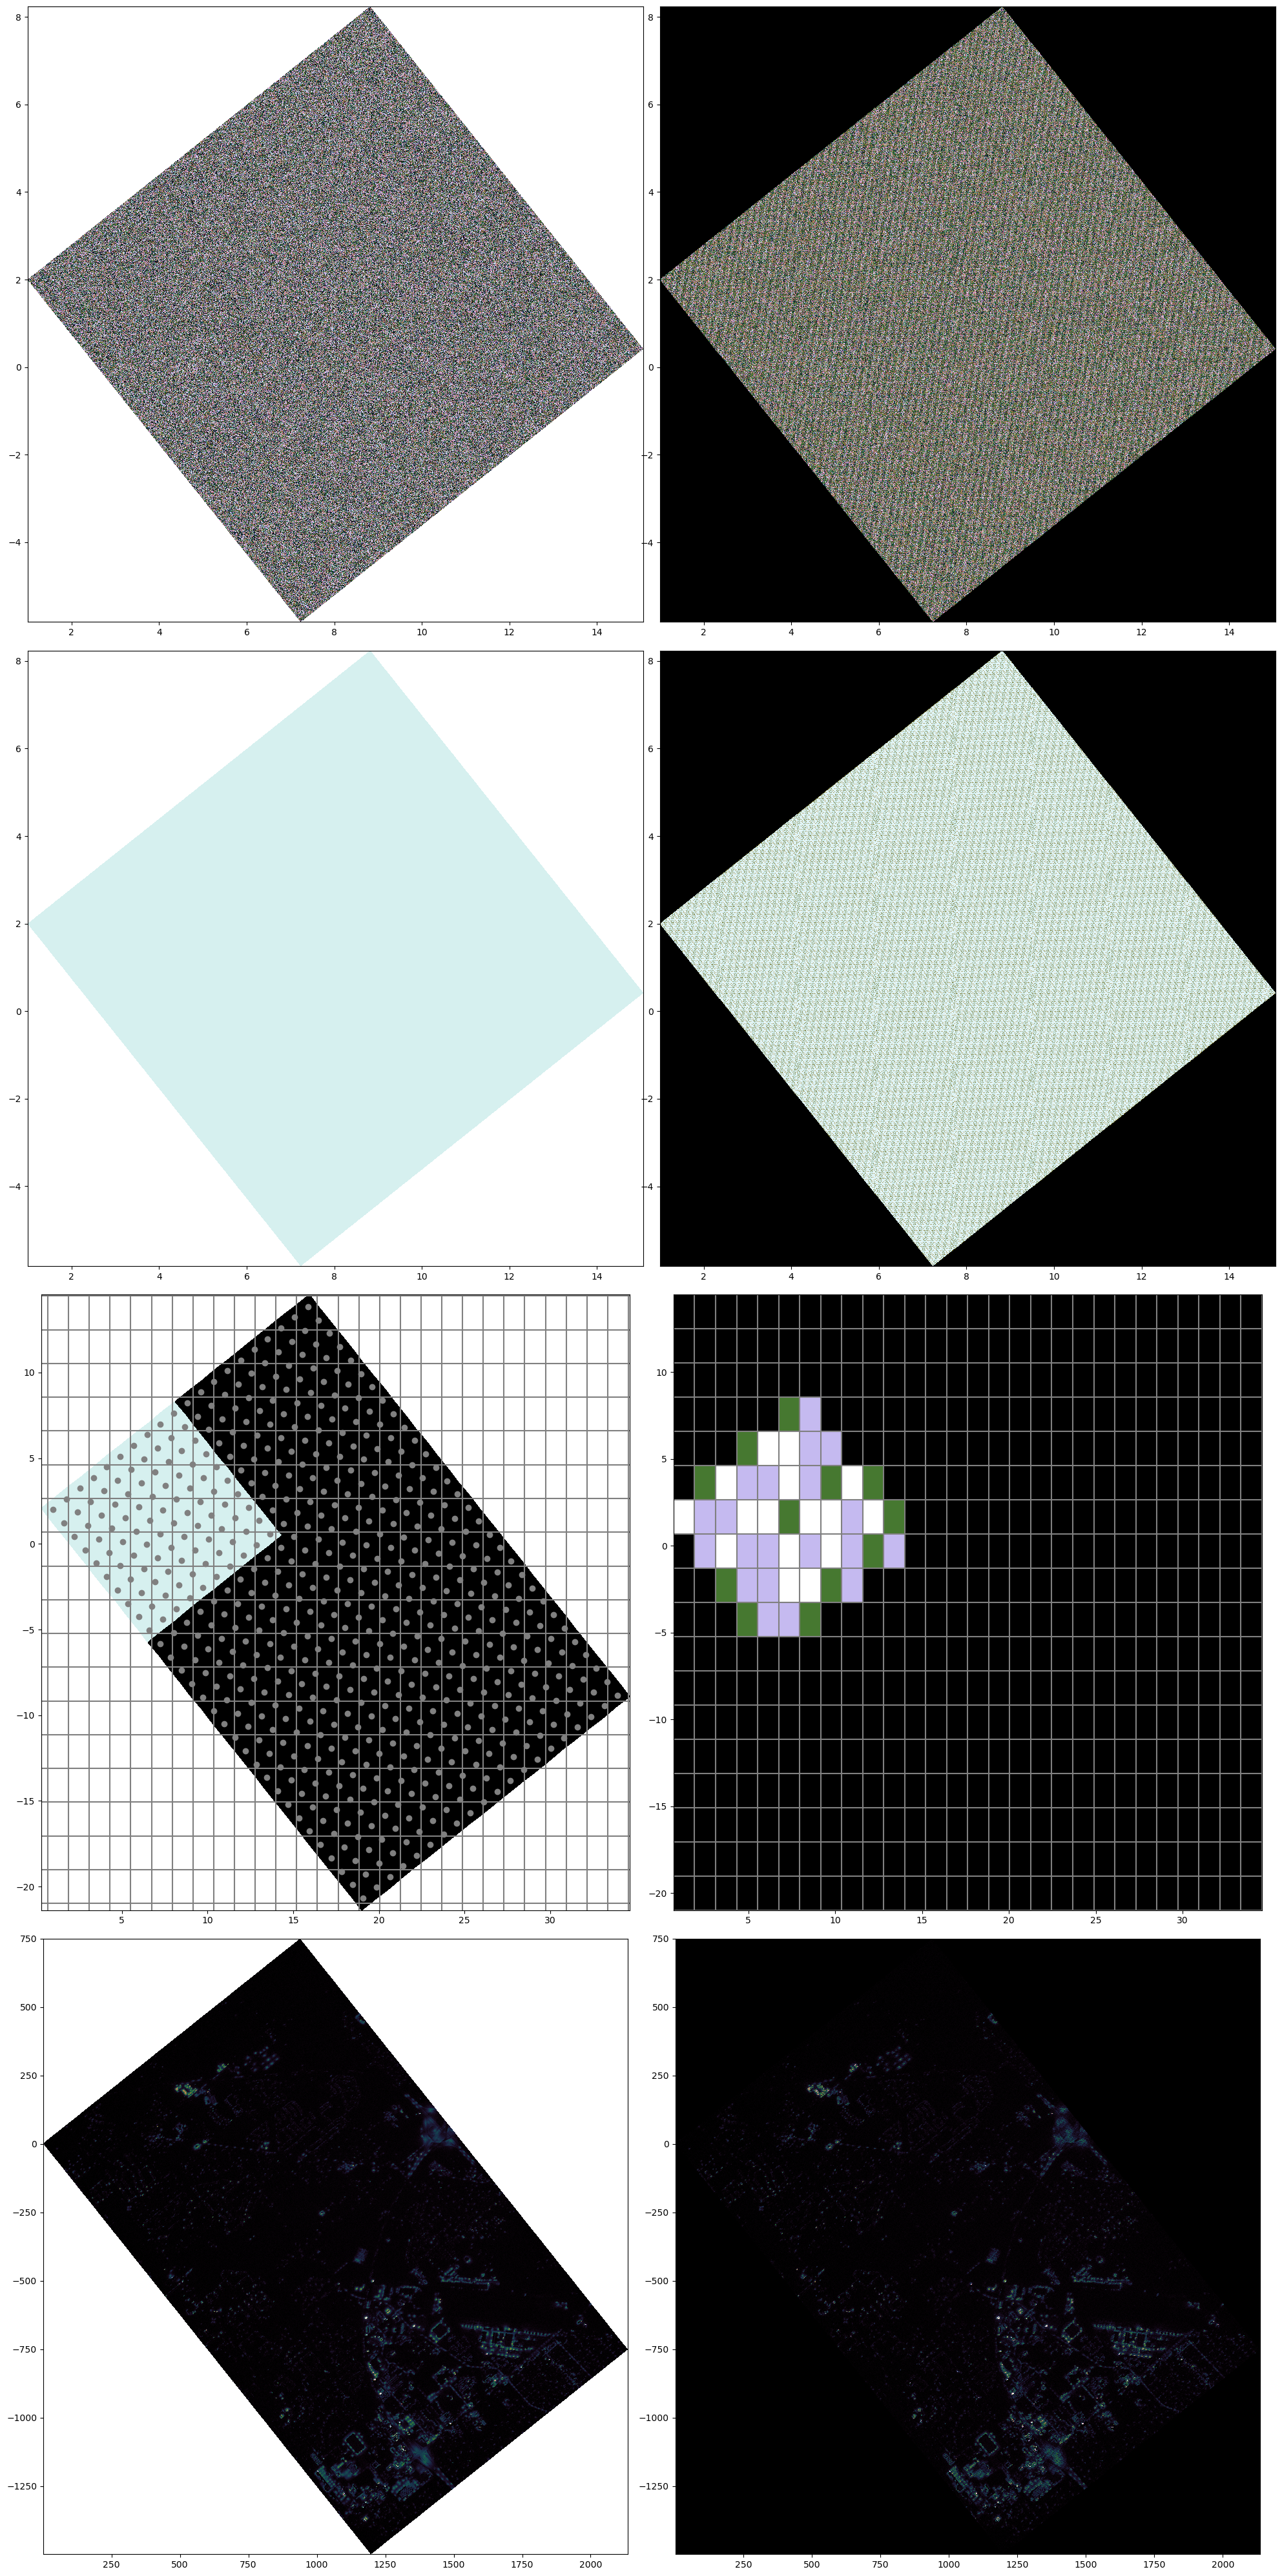

In [26]:
fig = plt.figure(figsize=(len(mosaic[0])*10,len(mosaic)*10))

ax_dict = fig.subplot_mosaic(mosaic)

# for method in methods:
for img_key in img_keys:
    
    start = time.time()
    
    itrans = georeference.ImageTransformer(imgs[img_key]['img'])
    
    (xs_resampled, ys_resampled), img_resampled = itrans.resample(imgs[img_key]['points'])
    
    time_taken = time.time() - start
    print('{} took {:.2g} seconds'.format(img_key, time_taken))
    if img_key == 'actual':
        print('   expected total of {:.2g} hr'.format(time_taken*len(fps)/3600))
        
    # vmax = np.max([[imgs[img_key]['img'].max(), img_resampled.max()]])
    vmax = 1.1
    
    ax = ax_dict['original_{}'.format(img_key)]
    ax.pcolormesh(
        imgs[img_key]['points'][0],
        imgs[img_key]['points'][1],
        imgs[img_key]['img'],
        vmin=0,
        vmax=vmax,
        cmap='cubehelix'
    )
    ax.set_aspect('equal')
    
    if img_key == 'orientation':
        for x in itrans.bins[0]:
            ax.axvline(x, color='0.5')
        for y in itrans.bins[1]:
            ax.axhline(y, color='0.5')
        ax.scatter(
            imgs[img_key]['points'][0].flatten(),
            imgs[img_key]['points'][1].flatten(),
            color = '0.5',
        )

    ax = ax_dict['resampled_{}'.format(img_key)]
    ax.pcolormesh(
        xs_resampled,
        ys_resampled,
        img_resampled,
        vmin=0,
        vmax=vmax,
        cmap='cubehelix'
    )
    ax.set_aspect('equal')
    
    if img_key == 'orientation':
        for x in itrans.bins[0]:
            ax.axvline(x, color='0.5')
        for y in itrans.bins[1]:
            ax.axhline(y, color='0.5')
    
plt.tight_layout()

## Assess Distribution Geometric Effects

In [27]:
shape = (20, 30)
flat_img = np.ones(shape)

In [28]:
xs_img_frame = np.linspace(0., 1., flat_img.shape[1])
ys_img_frame = np.linspace(0., 1., flat_img.shape[0])
points = get_rotated_coords(xs_img_frame, ys_img_frame)

In [29]:
xs, ys = points
dx_mean = np.mean(np.diff(xs, axis=1))
dy_mean = np.mean(np.diff(ys, axis=0))
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

In [30]:
dxs = np.linspace(0.4*dx_mean, 3.*dx_mean, 50)
dys = np.linspace(0.4*dy_mean, 3.*dy_mean, 50)

In [31]:
x_start = -dx_mean / 2.
y_start = -dy_mean / 2.

In [32]:
params = {
    'dx': [],
    'dy': [],
    'n_points': [],
}
counts = []

for dx in dxs:
    for dy in dys:

        x_bins = np.arange(x_min - x_start, x_max + dx, dx)
        y_bins = np.arange(y_min - y_start, y_max + dy, dy)
        
        # Calculation itself
        itrans = georeference.ImageTransformer(flat_img)
        (xs_resampled, ys_resampled), img_resampled = itrans.resample(
            points,
            (x_bins, y_bins),
            preserve_flux=False
        )
        
        # Process results
        counts_i, _ = np.histogram(
            img_resampled.flatten(),
            [-0.5, 0.5, 1.5, np.inf],
        )
        
        # Store results
        params['dx'].append(dx)
        params['dy'].append(dy)
        params['n_points'].append(img_resampled.size)
        counts.append(counts_i)
        
counts = np.array(counts)
for key, item in params.items():
    params[key] = np.array(item)

In [33]:
output = dict(
    f_ones = counts[:,1] / flat_img.size,
    f_high = counts[:,2] / flat_img.size,
    f_zeros = counts[:,0] / params['n_points'],
)

In [34]:
is_selected = (
    # (output['f_ones'] > 0.9)
    (output['f_zeros'] < np.inf)
)
# is_selected = True

In [35]:
params_selected = {}
for key, item in params.items():
    params_selected[key] = item[is_selected]
output_selected = {}
for key, item in output.items():
    output_selected[key] = item[is_selected]
counts_selected = counts[is_selected]

Text(0, 0.5, '1s fraction')

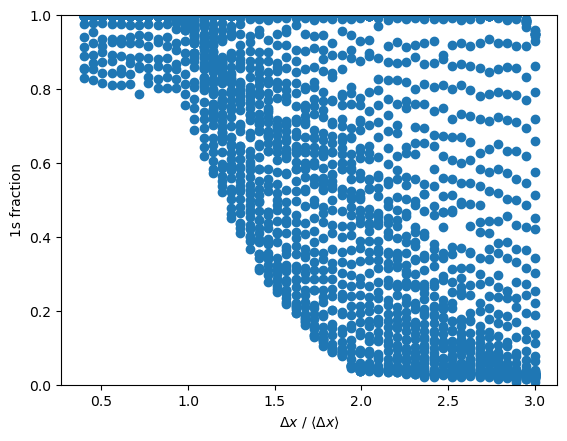

In [36]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(
    params_selected['dx'] / dx_mean,
    output_selected['f_ones'],
)

ax.set_ylim(0, 1)

ax.set_xlabel(r'$\Delta x$ / $\langle \Delta x \rangle$')
ax.set_ylabel(r'1s fraction')

Text(0, 0.5, '>1s fraction')

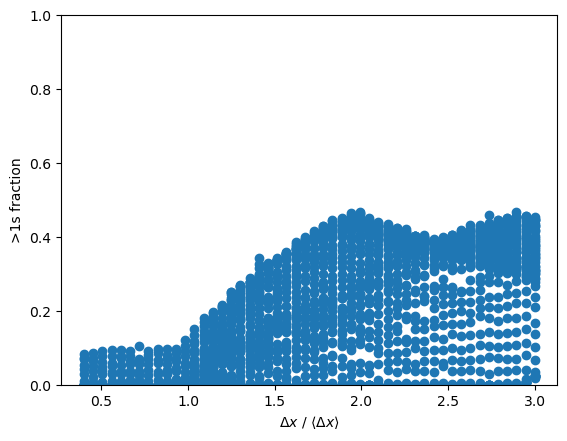

In [37]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(
    params_selected['dx'] / dx_mean,
    output_selected['f_high'],
)

ax.set_ylim(0, 1)

ax.set_xlabel(r'$\Delta x$ / $\langle \Delta x \rangle$')
ax.set_ylabel(r'>1s fraction')

Text(0, 0.5, '0s fraction')

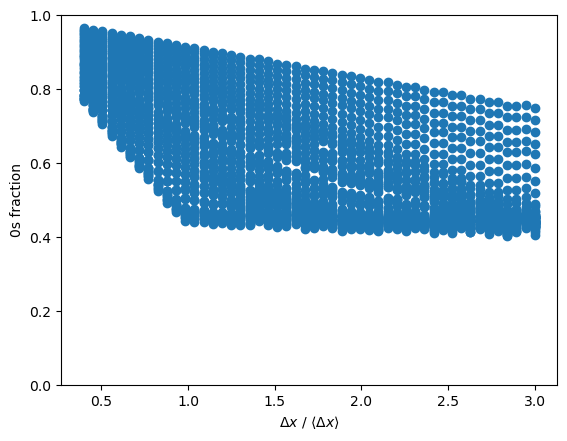

In [38]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(
    params_selected['dx'] / dx_mean,
    output_selected['f_zeros'],
)

ax.set_ylim(0, 1)

ax.set_xlabel(r'$\Delta x$ / $\langle \Delta x \rangle$')
ax.set_ylabel(r'0s fraction')

Text(0, 0.5, '$\\Delta y$ / $\\langle \\Delta y \\rangle$')

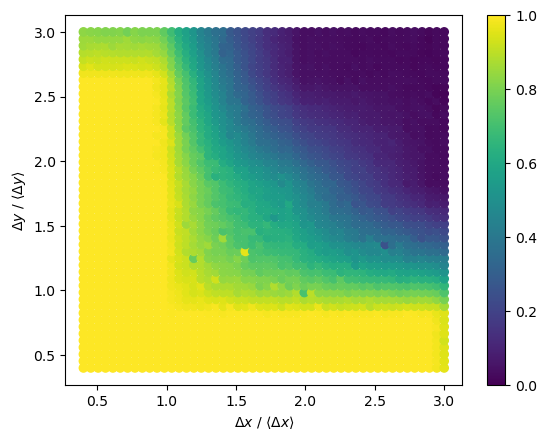

In [39]:
fig = plt.figure()
ax = plt.gca()

s = ax.scatter(
    params_selected['dx'] / dx_mean,
    params_selected['dy'] / dy_mean,
    c = output_selected['f_ones'],
    vmin = 0,
    vmax = 1.,
)
plt.colorbar(s)

ax.set_xlabel(r'$\Delta x$ / $\langle \Delta x \rangle$')
ax.set_ylabel(r'$\Delta y$ / $\langle \Delta y \rangle$')

In [40]:
i = 1
dx = params_selected['dx'][i]
dy = params_selected['dy'][i]

In [41]:
x_bins = np.arange(x_min - x_start, x_max + dx, dx)
y_bins = np.arange(y_min - y_start, y_max + dy, dy)

# Calculation itself
itrans = georeference.ImageTransformer(flat_img)
(xs_resampled, ys_resampled), img_resampled = itrans.resample(
    points,
    (x_bins, y_bins),
    preserve_flux=False
)

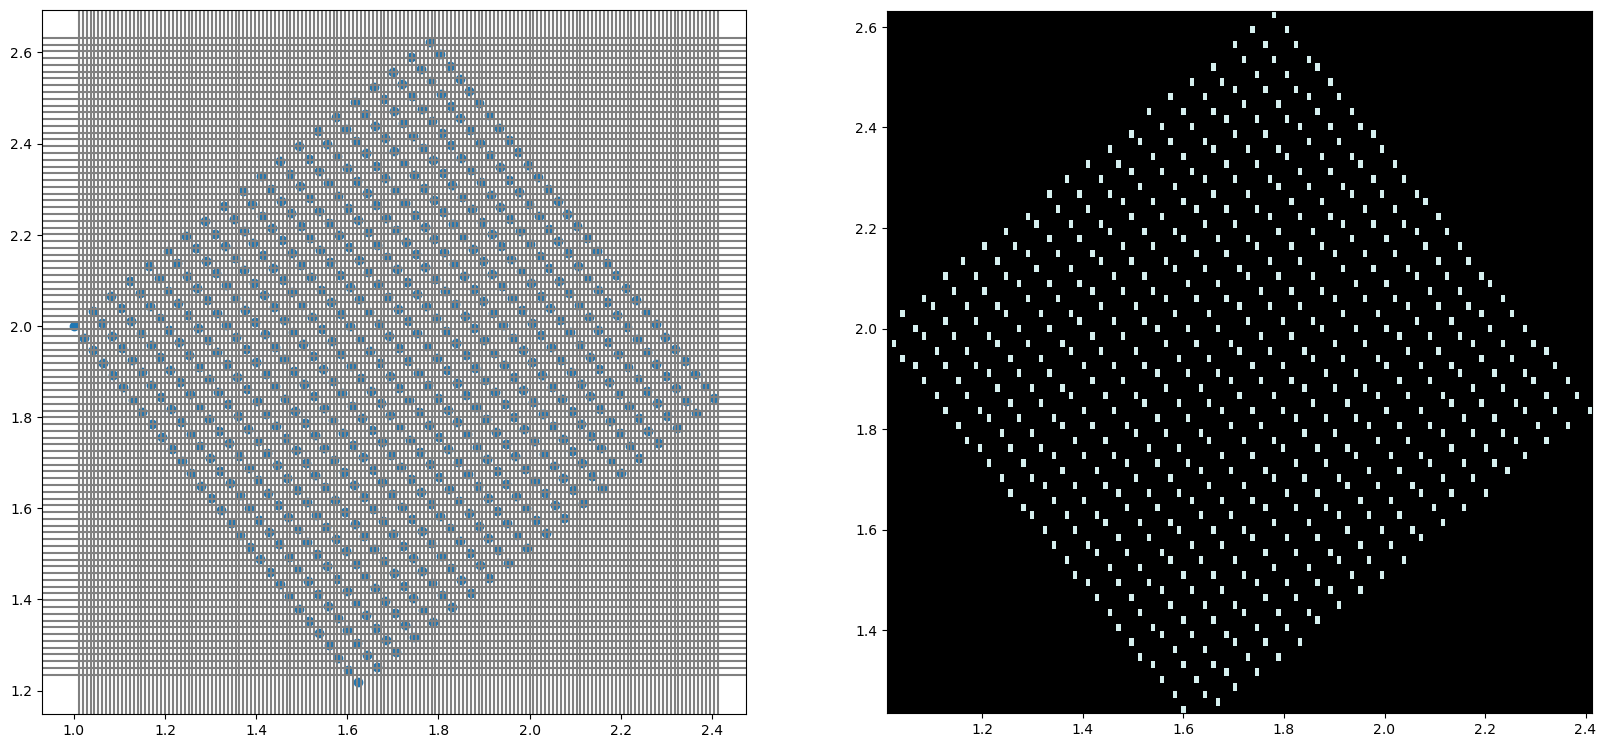

In [42]:
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic([['original', 'resampled']])

ax = ax_dict['original']
ax.scatter(
    xs,
    ys,
)

for x in x_bins:
    ax.axvline(x, color='0.5')
for y in y_bins:
    ax.axhline(y, color='0.5')
    
ax.set_aspect('equal')

ax = ax_dict['resampled']
ax.pcolormesh(
    xs_resampled,
    ys_resampled,
    img_resampled,
    vmin = 0,
    vmax = 1.1,
    cmap = 'cubehelix',
)

ax.set_aspect('equal')